# Classification Tumor

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.utils import make_grid
import os
import random
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive

In [3]:
torch.__version__

'2.2.1+cu121'

In [4]:
torch.cuda.empty_cache()

In [5]:
!nvidia-smi

Mon Apr  8 03:37:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
class BrainTumorDataset(Dataset):
  def __init__(self, images, labels):
    # images
    self.X = images
    # labels
    self.y = labels

    # Transformation for converting original image array to an image and then convert it to a tensor
    self.transform = transforms.Compose([transforms.ToPILImage(),
        transforms.ToTensor()
    ])



    # Transformation for converting original image array to an image, rotate it randomly between -90 degrees and 90 degrees, and then convert it to a tensor
    self.transform2 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(90),
        transforms.ToTensor()
    ])



    # Transformation for converting original image array to an image, rotate it randomly between -180 degrees and 180 degrees, and then convert it to a tensor
    self.transform4 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(180),
        transforms.ToTensor()
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -270 degrees and 270 degrees, and then convert it to a tensor
    self.transform5 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(270),
        transforms.ToTensor()
    ])



  def __len__(self):
    # return length of image samples
    return len(self.X)

  def __getitem__(self, idx):
    # perform transformations on one instance of X
    # Original image as a tensor
    data = self.transform(self.X[idx])


    # Augmented image at 90 degrees as a tensor
    aug90 = self.transform2(self.X[idx])


    # Augmented image at 180 degrees as a tensor
    aug180 = self.transform4(self.X[idx])

    # Augmented image at 270 degrees as a tensor
    aug270 = self.transform5(self.X[idx])


    # store the transformed images in a list
    new_batch = [data, aug90, aug180, aug270]

    # one-hot encode the labels
    labels = torch.zeros(4, dtype=torch.float32)
    labels[int(self.y[idx])] = 1.0

    new_labels = [labels, labels, labels, labels]

    # 8 augmented images and corresponding labels per sample will be returned
    return (torch.stack(new_labels), torch.stack(new_batch))

> **Load Dataset**

In [7]:
training_data = pickle.load(open('/content/drive/MyDrive/MRI/MoreData/classi_data.pickle', 'rb'))

In [8]:
Xt = []
yt = []
features = None
labels = None
label = []

In [9]:
for features,labels in training_data:
  Xt.append(features)
  yt.append(labels)

> **Train Val Test split**

In [10]:
X_train = None
X_test = None
y_train = None
y_test = None
X_valid = None
y_valid = None

In [11]:
# 60 % training, 20% validating, 20% testing
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, test_size=0.4, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)  # split testing set into 50% validation , 50% testing

In [12]:
Xt = None
yt = None
features = None
labels = None
label = None
training_data = None

In [13]:
train_set = BrainTumorDataset(X_train, y_train)
valid_set = BrainTumorDataset(X_valid, y_valid)
test_set = BrainTumorDataset(X_test, y_test)

In [14]:
print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_valid)}")
print(f"Number of testing samples: {len(X_test)}")

Number of training samples: 4213
Number of validation samples: 1405
Number of testing samples: 1405


In [15]:
print(f"Number of training samples: {len(X_train)*8}")
print(f"Number of validation samples: {len(X_valid)*8}")
print(f"Number of testing samples: {len(X_test)*8}")

Number of training samples: 33704
Number of validation samples: 11240
Number of testing samples: 11240


In [16]:
train_gen = DataLoader(train_set, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
valid_gen = DataLoader(valid_set, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
test_gen = DataLoader(test_set, batch_size=10, shuffle=True, pin_memory=True, num_workers=2)

In [17]:
print(f"Number of training samples: {len(train_gen)}")
print(f"Number of validation samples: {len(valid_gen)}")
print(f"Number of testing samples: {len(test_gen)}")

Number of training samples: 527
Number of validation samples: 176
Number of testing samples: 141


In [18]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

> **Build model**

In [ ]:
del resnet_model

In [19]:
# instantiate transfer learning model
resnet_model = models.resnet152(models.ResNet152_Weights.DEFAULT)

# set all paramters as trainable
for param in resnet_model.parameters():
    param.requires_grad = True

# get input of fc layer
n_inputs = resnet_model.fc.in_features

# redefine fc layer / top layer/ head for our classification problem
resnet_model.fc = nn.Sequential(nn.Linear(n_inputs, 2048),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 4),
                                nn.LogSigmoid())

# set all paramters of the model as trainable
for name, child in resnet_model.named_children():
  for name2, params in child.named_parameters():
    params.requires_grad = True

# set model to run on GPU or CPU absed on availibility
resnet_model.to(device)

# print the trasnfer learning NN model's architecture
resnet_model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 124MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
gpu = '0'
  # loss function
  # if GPU is available set loss function to use GPU
criterion = nn.CrossEntropyLoss().to(device)

base_lr = 1e-4
num_workers = 2
epochs = 10
is_optimize = True

  # optimizer
optimizer = torch.optim.Adam(resnet_model.parameters(), lr= base_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=0,
    verbose=True,
    min_lr=1e-10, )
  # number of training iterations

# empty lists to store losses and accuracies
train_losses = []
test_losses = []
train_correct = []
test_correct = []

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
def save_checkpoint(state, is_best, filename):
    torch.save(state, filename)

> **Train model**

In [21]:
%cd /content/drive/MyDrive/ColabNotebooks_own/MRI

/content/drive/MyDrive/ColabNotebooks_own/MRI


In [ ]:
# set training start time
start_time = time.time()

# set best_prec loss value as 2 for checkpoint threshold
best_prec1 = 2

# empty batch variables
b = None
train_b = None
test_b = None

# start training
for i in range(epochs):
    # empty training correct and test correct counter as 0 during every iteration
    trn_corr = 0
    tst_corr = 0

    # set epoch's starting time
    e_start = time.time()

    # train in batches
    for b, (y, X) in enumerate(train_gen):
        # set label as cuda if device is cuda
        X, y = X.to(device), y.to(device)

        # forward pass image sample
        y_pred = resnet_model(X.view(-1, 3, 256, 256))
        # calculate loss
        loss = criterion(y_pred, torch.argmax(y.view(-1, 4), dim=1).long())

        # get argmax of predicted tensor, which is our label
        predicted = torch.argmax(y_pred, dim=1).data
        # if predicted label is correct as true label, calculate the sum for samples
        batch_corr = (predicted == torch.argmax(y.view(-1, 4), dim=1)).sum()
        # increment train correct with correcly predicted labels per batch
        trn_corr += batch_corr

        # set optimizer gradients to zero
        optimizer.zero_grad()
        # back propagate with loss
        loss.backward()
        # perform optimizer step
        optimizer.step()

        #scheduler.step(loss)
        #base_lr = scheduler.get_last_lr()

    # set epoch's end time
    e_end = time.time()
    # print training metrics
    print(f'Epoch {(i+1)} Batch {(b+1)*4}\nAccuracy: {trn_corr.item()*100/(4*8*b):2.2f} %  Loss: {loss.item():2.4f}  Duration: {((e_end-e_start)/60):.2f} minutes') # 4 images per batch * 8 augmentations per image * batch length

    # some metrics storage for visualization
    train_b = b
    train_losses.append(loss)
    train_correct.append(trn_corr)

    X, y = None, None

    # validate using validation generator
    # do not perform any gradient updates while validation
    with torch.no_grad():
        for b, (y, X) in enumerate(valid_gen):
            # set label as cuda if device is cuda
            X, y = X.to(device), y.to(device)

            # forward pass image
            y_val = resnet_model(X.view(-1, 3, 256, 256))

            # get argmax of predicted tensor, which is our label
            predicted = torch.argmax(y_val, dim=1).data

            # increment test correct with correcly predicted labels per batch
            tst_corr += (predicted == torch.argmax(y.view(-1, 4), dim=1)).sum()

    # get loss of validation set
    loss = criterion(y_val.float(), torch.argmax(y.view(-1, 4), dim=1).long())
    scheduler.step(loss)
    # print validation metrics
    print(f'Validation Accuracy {tst_corr.item()*100/(4*8*b):2.2f} Validation Loss: {loss.item():2.4f}\n')

    # if current validation loss is less than previous iteration's validatin loss create and save a checkpoint
    is_best = loss < best_prec1
    best_prec1 = min(loss, best_prec1)

    # some metrics storage for visualization
    test_b  = b
    test_losses.append(loss)
    test_correct.append(tst_corr)

    torch.save(resnet_model.state_dict(), '/content/drive/My Drive/resnet152_Adam_classi.pt')
    with open('/content/drive/MyDrive/MRI/MoreData/result/classi_result.txt') as f:
      for i in range(epochs):
        f.write(f'{i+1}, {train_losses[i] }, {train_correct[i]* 100/(32*527)}, {test_losses[i]}, {test_correct[i] * 100/(176*32)}\n')
    f.close()

# set total training's end time
end_time = time.time() - start_time

# print training summary
print("\nTraining Duration {:.2f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.save(resnet_model.state_dict(), '/content/drive/My Drive/resnet152_Adam2_model.pt')

# Result and Evaluate

In [ ]:
print(f'Validation accuracy: {test_correct[-1].item()*100/(test_b*8*4):.2f}%')

Validation accuracy: 94.85%


In [ ]:
#if isinstance(train_correct, list) and isinstance(test_correct, list):
    # Convert each element in the lists to a tensor on the CPU
 #   train_correct = [torch.tensor(tst_corr, device='cpu') for loss in train_losses]
  #  test_correct = [torch.tensor(tst_corr, device='cpu') for loss in test_losses]
#else:
#    raise TypeError("train_losses and test_losses must be lists")

<ipython-input-72-0aabb36cb11e>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_correct = [torch.tensor(tst_corr, device='cpu') for loss in train_losses]
<ipython-input-72-0aabb36cb11e>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_correct = [torch.tensor(tst_corr, device='cpu') for loss in test_losses]


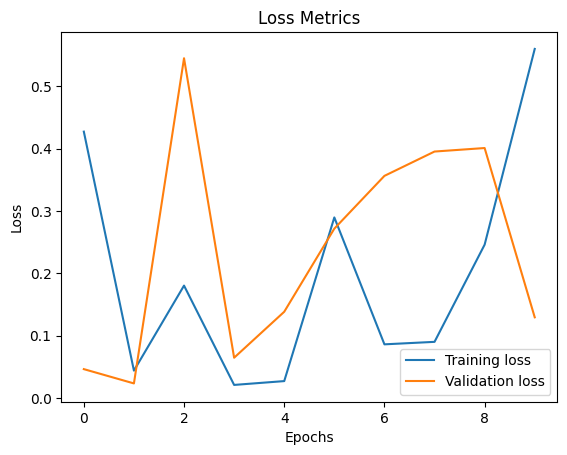

In [ ]:
train_losses = torch.tensor(train_losses)
test_losses = torch.tensor(test_losses)
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

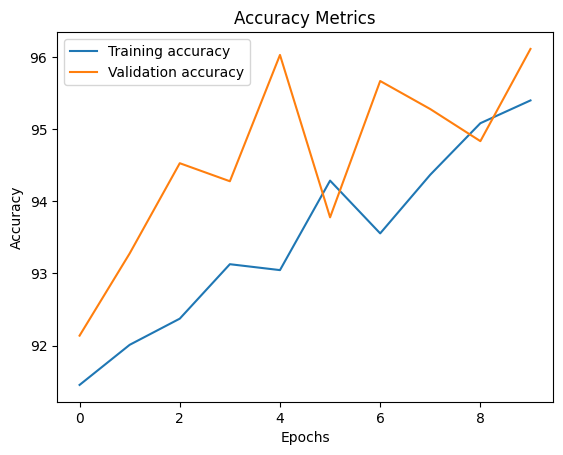

In [ ]:
train_correct = torch.tensor(train_correct)
test_correct = torch.tensor(test_correct)
plt.plot([t/171 for t in train_correct], label='Training accuracy')
plt.plot([t/36 for t in test_correct], label='Validation accuracy')
plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
arr = confusion_matrix(pred.view(-1).cpu(), labels.view(-1).cpu())
df_cm = pd.DataFrame(arr, LABELS, LABELS)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.show()

In [ ]:
resnet_model.load_state_dict(torch.load('/content/drive/MyDrive/resnet152_Adam2_model.pt'))
train_gen = None
valid_gen = None
train_set = None
valid_set = None

In [ ]:
# set model to evaluation mode
resnet_model.eval()

# perform no gradient updates
with torch.no_grad():
    # soem metrics storage for visualization and analysis
    correct = 0
    test_loss = []
    test_corr = []
    labels = []
    pred = []
    # perform test set evaluation batch wise
    for (y, X) in test_gen:
        # set label to use CUDA if available
        X, y = X.to(device), y.to(device)

        # append original labels
        labels.append(torch.argmax(y.view(10 * 8, 4), dim=1).data)

        # perform forward pass
        y_val = resnet_model(X.view(-1, 3, 256, 256))

        # get argmax of predicted values, which is our label
        predicted = torch.argmax(y_val, dim=1).data
        # append predicted label
        pred.append(predicted)

        # calculate loss
        loss = criterion(y_val.float(), torch.argmax(y.view(10 * 8, 4), dim=1).long())

        # increment correct with correcly predicted labels per batch
        correct += (predicted == torch.argmax(y.view(10 * 8, 4), dim=1)).sum()

        # append correct samples labels and losses
        test_corr.append(correct)
        test_loss.append(loss)

print(f"Test Loss: {test_loss[-1].item():.4f}")

Test Loss: 0.0257


In [ ]:
print(f'Test accuracy: {test_corr[-1].item()*100/(460*8):.2f}%')

Test accuracy: 96.85%


In [ ]:
labels = torch.stack(labels)
pred = torch.stack(pred)

In [ ]:
LABELS = ['Meningioma', 'Glioma', 'Pitutary']

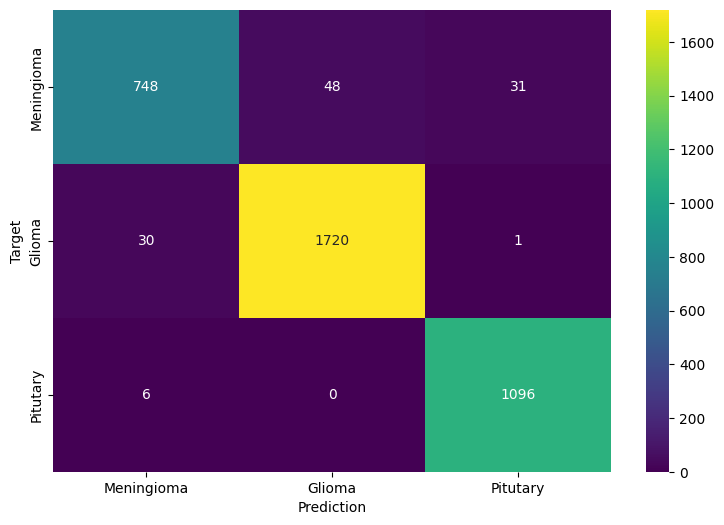

In [ ]:
arr = confusion_matrix(pred.view(-1).cpu(), labels.view(-1).cpu())
df_cm = pd.DataFrame(arr, LABELS, LABELS)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.show()

In [ ]:
cd